In [ ]:
# Imports
%load_ext autoreload
%aimport sym
%autoreload 1
import os 
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning.callbacks import ModelCheckpoint
import torchvision
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sym import LCN, ProgressBar, Classification_report, Logger
from sym.utils import utils
device = "cuda:0" if torch.cuda.is_available() else "cpu"
plt.style.use('dark_background')

In [ ]:
testset = torch.load("./data/testset.pt")
trainset = torch.load("./data/trainset.pt")
trainset, valset = torch.utils.data.random_split(trainset,[55000,5000])
trainloader = torch.utils.data.DataLoader(trainset, num_workers=6, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, num_workers=6)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, num_workers=6)
del testset, trainset, valset

Text(0.5, 0.91, 'Validation Data')

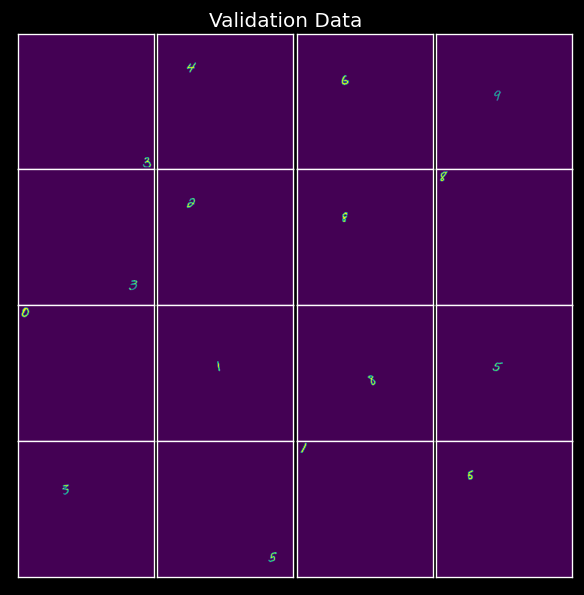

In [3]:
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
x,y = next(iter(trainloader))
for img,label, ax in zip(x,y,axes.flatten()):
    ax.imshow(img.squeeze().numpy())
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0)
fig.suptitle("Validation Data", y=.91)

In [4]:
# Aggregate validation losses -> DONE!
# Change back to SGD -> DONE!
# Reporoduce their experiments -> DONE!
# Fix LCN Code -> DONE!
# Think about better problem statement for CNN vs LCN
# Shit on computaional separation paper (for not having large enough FCN)
# Show that the bounds are consistent
# By Friday have 5 pages

In [5]:
logdir = "./lightning_logs/MNIST/DIAG/SGD/"
if not os.path.exists(logdir): os.makedirs(logdir,exist_ok=True)
epochs = 40
nfilters = 256
stride = 28
kernel_size = 28
hidden = 64
lr = 1e-3

In [6]:
# Train the CNN 
module = sym.models.CNN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
cnn = sym.models.Model(module,
    optim=torch.optim.SGD(module.parameters(),lr=lr))

In [7]:
# Run
pl.seed_everything(42)
bar = sym.utils.ProgressBar()
log = sym.utils.Logger(logdir, name="CNN",default_hp_metric=False)
path = logdir+f"CNN/version_{log.version}"
checkpoint_callback = ModelCheckpoint(dirpath=path,filename="weights.cpkt",save_top_k=1,monitor='val_loss',mode='min')
trainer = pl.Trainer(logger=log, gpus=1, max_epochs=epochs, progress_bar_refresh_rate=1,callbacks=[bar,checkpoint_callback])
trainer.fit(cnn,train_dataloader=trainloader,val_dataloaders=valloader)

Missing logger folder: ./lightning_logs/MNIST/SGD/CNN
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 1.8 M 


Epoch 9: 100%|##########| 1876/1876 [00:19<00:00, 94.72it/s, loss=0.016, v_num=0, val_loss=0.0161, val_acc=0.894] 


1

# LCN 

In [8]:
# Train the LCN 
module = sym.models.LCN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
lcn = sym.models.Model(module,
    optim=torch.optim.SGD(module.parameters(),lr=lr))

In [9]:
# Run
pl.seed_everything(42)
bar = sym.utils.ProgressBar()
log = sym.utils.Logger(logdir, name="LCN",default_hp_metric=False)
path = logdir+f"LCN/version_{log.version}"
checkpoint_callback = ModelCheckpoint(dirpath=path,filename="weights.cpkt",save_top_k=1,monitor='val_loss',mode='min')
trainer = pl.Trainer(logger=log, gpus=1, max_epochs=epochs, progress_bar_refresh_rate=1,callbacks=[bar,checkpoint_callback])
trainer.fit(lcn,train_dataloader=trainloader,val_dataloaders=valloader)

Missing logger folder: ./lightning_logs/MNIST/SGD/LCN
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | LCN  | 21.7 M


Epoch 9: 100%|##########| 1876/1876 [01:20<00:00, 23.20it/s, loss=0.026, v_num=0, val_loss=0.0261, val_acc=0.826]


1

# FCN 

In [10]:
# Train the FCN 
module = sym.models.FCN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
fcn = sym.models.Model(module,
    optim=torch.optim.SGD(module.parameters(),lr=lr))

In [11]:
# Run
pl.seed_everything(42)
bar = sym.utils.ProgressBar()
log = sym.utils.Logger(logdir, name="FCN",default_hp_metric=False)
path = logdir+f"FCN/version_{log.version}"
checkpoint_callback = ModelCheckpoint(dirpath=path,filename="weights.cpkt",save_top_k=1,monitor='val_loss',mode='min')
trainer = pl.Trainer(logger=log, gpus=1, max_epochs=epochs, progress_bar_refresh_rate=1,callbacks=[bar,checkpoint_callback])
trainer.fit(fcn,train_dataloader=trainloader,val_dataloaders=valloader)

Missing logger folder: ./lightning_logs/MNIST/SGD/FCN
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | FCN  | 20.1 M


Epoch 9: 100%|##########| 1876/1876 [00:20<00:00, 91.20it/s, loss=0.009, v_num=0, val_loss=0.0122, val_acc=0.921]


1

Text(0.5, 0.91, 'CNN Filters')

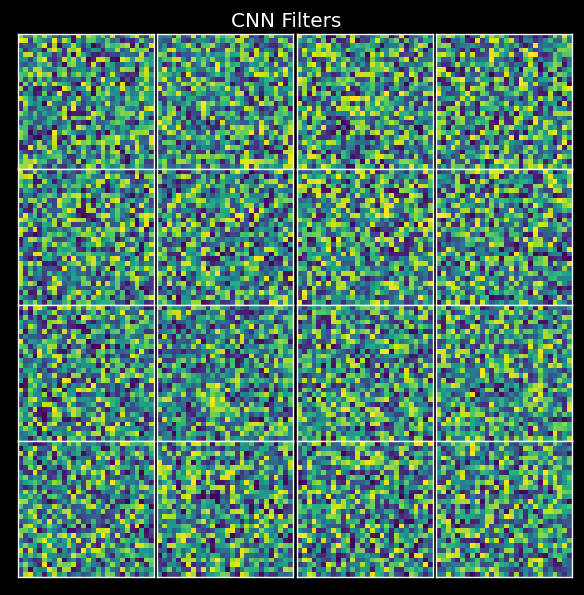

In [14]:
weights_cnn = next(cnn.model.parameters()).detach().cpu().squeeze()
filters_cnn = utils.minmaxnorm(weights_cnn)
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_cnn,axes.flatten()):
    ax.imshow(img.numpy())
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0)
fig.suptitle("CNN Filters", y=.91)

In [12]:
weights_fcn = next(fcn.model.parameters()).detach().cpu()
filters_fcn = utils.minmaxnorm(weights_fcn)

Text(0.5, 0.91, 'FCN Filters')

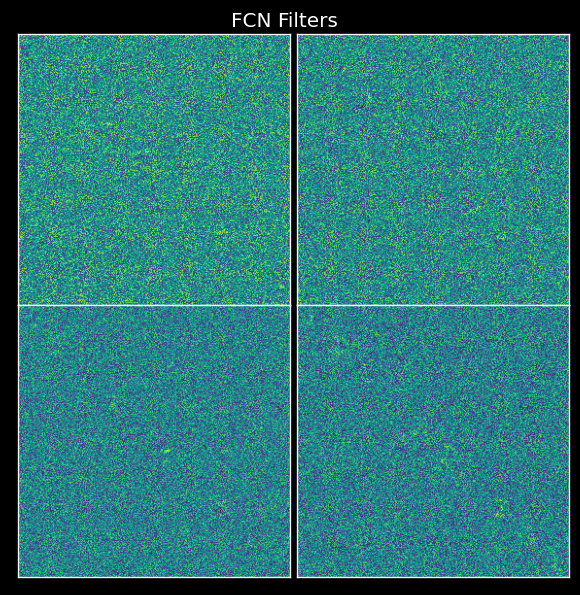

In [13]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_fcn[100:],axes.flatten()):
    ax.imshow(img.view(280,280).numpy())
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0)
fig.suptitle("FCN Filters", y=.91)

In [15]:
weights_lcn = next(lcn.model.parameters()).detach().cpu().squeeze()
weights_lcn = weights_lcn.unflatten(0,(nfilters,10,10)) #get filter locations
weights_lcn = weights_lcn.permute(0,1,3,2,4) # height and width next to each other
weights_lcn = weights_lcn.flatten(1,2).flatten(2,3)

Text(0.5, 0.91, 'LCN Filters')

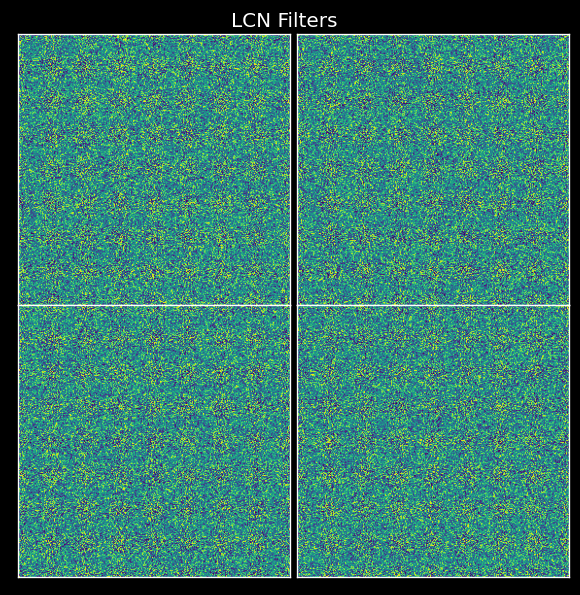

In [16]:
filters_lcn = utils.minmaxnorm(weights_lcn)
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_lcn[200:],axes.flatten()):
    ax.imshow(img.numpy())
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0)
fig.suptitle("LCN Filters", y=.91)

# Testing

In [ ]:
# Load weights
nfilters = 256
stride = 28
kernel_size = 28
hidden = 64
optim=torch.optim.SGD
module = sym.models.FCN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
fcn = sym.models.Model(module, optim=optim(module.parameters()))
fcn.load_from_checkpoint("lightning_logs/MNIST/DIAG/SGD/FCN/version_0/weights.cpkt-v0.ckpt", model = module, optim=optim(module.parameters()))
module = sym.models.CNN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
cnn = sym.models.Model(module,optim=optim(module.parameters()))
cnn.load_from_checkpoint("lightning_logs/MNIST/DIAG/SGD/CNN/version_0/weights.cpkt-v0.ckpt", model = module, optim=optim(module.parameters()))
module = sym.models.LCN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
lcn = sym.models.Model(module,optim=optim(module.parameters()))
lcn.load_from_checkpoint("lightning_logs/MNIST/DIAG/SGD/LCN/version_0/weights.cpkt-v0.ckpt", model=module, optim=optim(module.parameters()))
print("Models loaded successfully!")

In [ ]:
testset_rand = torch.load("./data/testset_rand.pt")
testloader_rand = torch.utils.data.DataLoader(testset_rand, batch_size=32, num_workers=6)
del testset_rand

In [ ]:
trainer = pl.Trainer(callbacks=[bar])
cnn_tests = [trainer.test(cnn,testloader)]
lcn_tests = [trainer.test(lcn,testloader)]
fcn_tests = [trainer.test(fcn,testloader)]
cnn_tests.append(trainer.test(cnn,testloader_rand))
lcn_tests.append(trainer.test(lcn,testloader_rand))
fcn_tests.append(trainer.test(fcn,testloader_rand))

In [39]:
fcn_acc_diag = np.mean([x["val_acc"] for x in fcn_tests[0]])
fcn_acc_rand = np.mean([x["val_acc"] for x in fcn_tests[1]])
cnn_acc_diag = np.mean([x["val_acc"] for x in cnn_tests[0]])
cnn_acc_rand = np.mean([x["val_acc"] for x in cnn_tests[1]])
lcn_acc_diag = np.mean([x["val_acc"] for x in lcn_tests[0]])
lcn_acc_rand = np.mean([x["val_acc"] for x in lcn_tests[1]])
print(f"CNN accuracy on diag test data:   {cnn_acc_diag:<6.3f}")
print(f"CNN accuracy on sparse test data: {cnn_acc_rand:<6.3f}")
print(f"LCN accuracy on diag test data:   {lcn_acc_diag:<6.3f}")
print(f"LCN accuracy on sparse test data: {lcn_acc_rand:<6.3f}")
print(f"FCN accuracy on diag test data:   {fcn_acc_diag:<6.3f}")
print(f"FCN accuracy on sparse test data: {fcn_acc_rand:<6.3f}")

CNN accuracy on diag test data:   0.887 
CNN accuracy on sparse test data: 0.182 
LCN accuracy on diag test data:   0.804 
LCN accuracy on sparse test data: 0.171 
FCN accuracy on diag test data:   0.900 
FCN accuracy on sparse test data: 0.189 
